# Kaggle Titanic Project :

In [1]:
# Libraries :
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time

from scipy.stats import uniform, randint

# Model dev part :
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neural_network import MLPClassifier

import tensorflow as tf

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Datas :

    Variable |	Definition	     |  Key
    survival |	Survival 	     |  0 = No, 1 = Yes
    pclass 	 |  Ticket class 	 |  1 = 1st, 2 = 2nd, 3 = 3rd
    sex 	 |  Sex
    Age 	 |  Age in years
    sibsp 	 |  # of siblings / spouses aboard the Titanic
    parch 	 |  # of parents / children aboard the Titanic
    ticket 	 |  Ticket number
    fare 	 |  Passenger fare
    cabin 	 |  Cabin number
    embarked |  Port of Embarkation  | C = Cherbourg, Q = Queenstown, S = Southampton

In [ ]:
path=Path('train.csv').parent.absolute()

train=pd.read_csv(path/'data/train.csv')
test=pd.read_csv(path/'data/test.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/content/data/train.csv'

## Exploration Data Analysis :

### Global exploration :

In [ ]:
print("Shape of train :", train.shape)
print("Shape of test :", test.shape, "\n")

print("Percentage by category (0=Died) :\n", train['Survived'].value_counts()/len(train)*100,"\n")

print(train.info())

In [ ]:
train.drop(['Ticket','PassengerId'],axis=1,inplace=True) # I will delete them because I don't think ticket's number and PassengerId will be useful for predictions
test.drop(['Ticket','PassengerId'],axis=1,inplace=True)

In [ ]:
for col in train.columns :
    if train[col].dtype == 'object' :
        print(col, " :\n", train[col].value_counts())
    elif train[col].dtype in ['float64','int64'] :
        print(col, " :\n", train[col].describe())
    print("\n")

In [ ]:
train['Sex'] = (train['Sex'] == 'male').astype('int64') # Change type of Sex to int (0=Female 1=Male)
test['Sex'] = (test['Sex'] == 'male').astype('int64') # Change type of Sex to int (0=Female 1=Male)

In [ ]:
# The full name won't be useful for prediction but the title may (Mr, Mrs, ...) as seen in Manav SEHGAL's notebook : https://www.kaggle.com/code/startupsci/titanic-data-science-solutions/notebook
train['Title']=train.Name.str.extract(' ([A-Za-z]+)\.',expand=False)
test['Title']=test.Name.str.extract(' ([A-Za-z]+)\.',expand=False)

count = pd.concat([train['Title'],test['Title']],axis=0).value_counts()

print(count)

In [ ]:
train['Title'] = train['Title'].replace(count[count<10].index,'Rare')
test['Title'] = test['Title'].replace(count[count<10].index,'Rare')

count = pd.concat([train['Title'],test['Title']],axis=0).value_counts()
print(count)

train.drop('Name',axis=1,inplace=True)
test.drop('Name',axis=1,inplace=True)

In [ ]:
# Let's also create a family size feature : SibSp + Parch + 1 (spouses / sibling + parent / child + the person)
train['Family size'] = train['SibSp'] + train['Parch'] + 1
test['Family size'] = test['SibSp'] + test['Parch'] + 1

In [ ]:
train.shape, test.shape

### Missing :

In [ ]:
data = pd.concat([train.drop('Survived',axis=1),test],axis=0)

miss=pd.concat([data.isna().sum(),data.isna().sum()/len(data)*100,data.dtypes],axis=1)
miss.columns=['Count','Percentage','Type']
miss=miss.sort_values(by='Count',ascending=False)
miss[miss['Count']>0]

In [ ]:
print('Embarked :\n',data['Embarked'].value_counts()) # For this one let's take mode
print('Fare :\n', data['Fare'].describe()) # A very large dispersion : i'll take the median
print('Age :\n', data['Age'].describe()) # Relatively close, only 1 year between median and mean. Let's take the mean

In [ ]:
data['Embarked']=data['Embarked'].fillna(data['Embarked'].mode()[0])
data['Age']=data['Age'].fillna(data['Age'].mean())
data['Fare']=data['Fare'].fillna(data['Fare'].median())
#data['Cabin']=data['Cabin'].fillna('Unknow')
data.drop('Cabin',axis=1,inplace=True)

In [ ]:
miss=pd.concat([data.isna().sum(),data.isna().sum()/len(data)*100,data.dtypes],axis=1)
miss.columns=['Count','Percentage','Type']
miss=miss.sort_values(by='Count',ascending=False)
miss[miss['Count']>0]

In [ ]:
labels=['0-15','15-35','35-65','65+']
bins=[0,15,35,65,120]
data['AgeBand']=pd.cut(data['Age'],bins,labels=labels,include_lowest=True)
# 0 - 15 y.o (excluded)
# 15 - 35 y.o (excluded)
# 35 - 65 y.o (excluded)
# 65 +

In [ ]:
data=pd.get_dummies(data)

train=pd.concat([data.iloc[:len(train),],train['Survived']],axis=1)
test=data.iloc[len(train):,]

train.shape, test.shape

### Correlation :

In [ ]:
corr=train.corr('spearman')
sns.heatmap(corr)

In [ ]:
sns.barplot(corr['Survived'].sort_values()[:-1],orient='h')

## Model Creation :

In [ ]:
# Separating features :
y=train['Survived']
train.drop('Survived',axis=1,inplace=True)

# Normalization :
scaler=StandardScaler()
scaler.fit(train)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

print(train_scaled.shape, test_scaled.shape)

# Splitting in train / test :
X_train, X_test, y_train, y_test = train_test_split(train_scaled, y, test_size=0.3, random_state=1, shuffle=True) # 70/30%

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Hyperparameters optimisation :
def cv(model,distrib,X=X_train,y=y_train) :
    process = RandomizedSearchCV (estimator=model,param_distributions=distrib,n_iter=50,scoring="accuracy",cv=5,verbose=0,n_jobs=-1,random_state=1)
    process.fit(X,y)
    return process.best_params_, process.best_score_

In [ ]:
# Define the differents models and there distribution for RandomCV :

reglog=LogisticRegression()
reglog_distrib = {'C': uniform(0.0001,100), 'max_iter': [100, 200, 500]}

knn=KNeighborsClassifier()
knn_distrib = {'n_neighbors' : randint(3,20), 'weights' : ['uniform','distance'],}

svc = SVC()
svc_distrib = {'C': uniform(0.0001,100), 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'degree': randint(2,5), 'gamma': ['scale', 'auto'], 'coef0': uniform(0,1)}

rf = RandomForestClassifier()
rf_distrib = {'n_estimators' : randint(50,501), 'max_depth':[None, 10, 20, 30, 50], 'min_samples_split': randint(2,11),
           'min_samples_leaf': randint(1,6), 'max_features':["sqrt", "log2", None]}

xgb = XGBClassifier()
xgb_distrib = {'n_estimators' : randint(50,501), 'max_depth': randint(1,11), 'subsample': uniform(0.5,0.5), 'learning_rate' : uniform(0.001,0.3), 'colsample_bytree': uniform(0.5,0.5),
            'gamma' : uniform(0,5), 'reg_alpha' : uniform(0.1,10), 'reg_lambda' : uniform(0.1,10)}

lgb = LGBMClassifier(verbose=-1)
lgb_distrib = {'n_estimators' : randint(50,501), 'max_depth': randint(1,11), 'subsample': uniform(0.5,0.5), 'learning_rate' : uniform(0.001,0.3), 'colsample_bytree': uniform(0.5,0.5),
            'reg_alpha' : uniform(0.1,10), 'reg_lambda' : uniform(0.1,10), 'num_leaves' : randint(10,70)}

mlp = MLPClassifier(max_iter=500,random_state=1,verbose=0)
mlp_distrib = {
    'hidden_layer_sizes': [(8,), (16,), (32,), (64,), (128,), (256,), (8,8), (16,16), (32, 32), (64, 64), (128, 128), (256, 256)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['adam', 'lbfgs','sgd'], # solver lbfgs said to work well with small datasets
    'alpha': uniform(0.0001, 10),
    'learning_rate': ['constant', 'adaptive','invscaling']}

models = [reglog, knn, svc, rf, xgb, lgb,mlp]
distribs = [reglog_distrib, knn_distrib, svc_distrib, rf_distrib, xgb_distrib, lgb_distrib,mlp_distrib]
model_names=['Logistic Reg','KNN','SVC','RandomForest','Xgboost','LightGB','MLP']

In [ ]:
# Optimization :
params=dict()
res=dict()
times=dict()
for (model, distrib, model_name) in zip(models,distribs,model_names) :
    print(model_name)
    start=time.time()
    param, score =cv(model,distrib)
    end=time.time()
    print(end-start)
    params[model_name]=param
    res[model_name]=score
    times[model_name]=end-start

In [ ]:
res

In [ ]:
# Save the optimized hyperparameters :
MODEL_PATH=Path("Models parameters & Data")
MODEL_PATH.mkdir(parents=True,exist_ok=True)
MODEL_SAVE_PATH = MODEL_PATH/'saved_dictionary.pkl'

print(f"Saving parameters to {MODEL_PATH/'saved_params.pkl'}")
with open(MODEL_PATH/'saved_params.pkl', 'wb') as f:
    pickle.dump(params, f)

print(f"Saving scores to {MODEL_PATH/'saved_scores_cv.pkl'}")
with open(MODEL_PATH/'saved_scores_cv.pkl', 'wb') as f:
    pickle.dump(res, f)

print(f"Saving times to {MODEL_PATH/'saved_times_cv.pkl'}")
with open(MODEL_PATH/'saved_times_cv.pkl', 'wb') as f:
    pickle.dump(times, f)

print(f"Saving data in {MODEL_PATH} folder")
train.to_csv(MODEL_PATH/'train_final.csv', index=False)
test.to_csv(MODEL_PATH/'test_final.csv', index=False)
y.to_csv(MODEL_PATH/'y_final.csv', index=False)

Saving parameters to Models parameters & Data/saved_params.pkl


NameError: name 'params' is not defined

## Loads:

In [ ]:
path=Path(Path('train_final.csv').parent.absolute(),Path("Models parameters & Data"))
with open(path/'saved_params.pkl', 'rb') as f: # Optimized parameters
    loaded_dict = pickle.load(f)

with open(path/'saved_scores_cv.pkl', 'rb') as f: # Score for the optimized parameters
    loaded_scores = pickle.load(f)

with open(path/'saved_times_cv.pkl', 'rb') as f: # times taken to optimize the parameters
    loaded_times = pickle.load(f)

# Data :
tr=pd.read_csv(path/'train_final.csv')
te=pd.read_csv(path/'test_final.csv')
y=pd.read_csv(path/'y_final.csv')

# Normalization :
scaler=StandardScaler()
scaler.fit(tr)
train_scaled = scaler.transform(tr)
test_scaled = scaler.transform(te)

print(train_scaled.shape, test_scaled.shape, y.shape)

# Splitting in train / test :
X_train, X_test, y_train, y_test = train_test_split(train_scaled,y,test_size=0.3,random_state=1,shuffle=True) # 70/30%

# Models :
reglog = LogisticRegression(**loaded_dict['Logistic Reg'])

knn = KNeighborsClassifier(**loaded_dict['KNN'])

svc = SVC(**loaded_dict['SVC'])

rf = RandomForestClassifier(**loaded_dict['RandomForest'])

xgb = XGBClassifier(**loaded_dict['Xgboost'])

lgb = LGBMClassifier(**loaded_dict['LightGB'],verbose=-1)

mlp = MLPClassifier(**loaded_dict['MLP'],random_state=1,verbose=0)

models = [reglog, knn, svc, rf, xgb, lgb,mlp]
model_names=['Logistic Reg','KNN','SVC','RandomForest','Xgboost','LightGB','MLP']

(891, 19) (418, 19) (891, 1)


In [ ]:
# Ensemble Models:
base_models = [
    ('reglog', reglog),
    ('knn', knn),
    ('svc', svc),
    ('rf', rf),
    ('xgb', xgb),
    ('lgb', lgb),
    ('mlp',mlp)
]

voting_model = VotingClassifier(estimators=base_models, voting='hard')

voting_model

VotingClassifier(estimators=[('reglog',
                              LogisticRegression(C=41.702300470257406)),
                             ('knn', KNeighborsClassifier(n_neighbors=8)),
                             ('svc',
                              SVC(C=31.342517815924285,
                                  coef0=0.6923226156693141, kernel='linear')),
                             ('rf',
                              RandomForestClassifier(max_depth=30,
                                                     max_features=None,
                                                     min_samples_leaf=2,
                                                     min_samples_split=10,
                                                     n_estimators=80)),
                             ('xgb',
                              XGBClassifier(base_score=...
                              LGBMClassifier(colsample_bytree=0.7921945603689646,
                                             learning_rate=0.17077360823925794,
                                             max_depth=8, n_estimators=293,
                                             num_leaves=38,
                                             reg_alpha=5.993055369032842,
                                             reg_lambda=7.097583600209312,
                                             subsample=0.5511672144139129,
                                             verbose=-1)),
                             ('mlp',
                              MLPClassifier(activation='logistic',
                                            alpha=4.930695935447459,
                                            hidden_layer_sizes=(8,),
                                            random_state=1, solver='lbfgs',
                                            verbose=0))])

In [ ]:
# Fitting the models to train data :
for (model,model_name) in zip(models,model_names) :
    model.fit(X_train,y_train.values.ravel());

voting_model.fit(X_train, y_train.values.ravel());

# Evaluate the generalization capacity of our models on a test set we kept :
preds_test=pd.DataFrame(np.zeros([len(X_test),len(models)+1]),columns=[*model_names,"Voting"])
res_test=list()
for (model,model_name) in zip(models,model_names) :
    preds_test[model_name]=model.predict(X_test)
    res_test.append(accuracy_score(y_test,preds_test[model_name]))
preds_test['Voting']=voting_model.predict(X_test)
res_test.append(accuracy_score(y_test,preds_test['Voting']))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


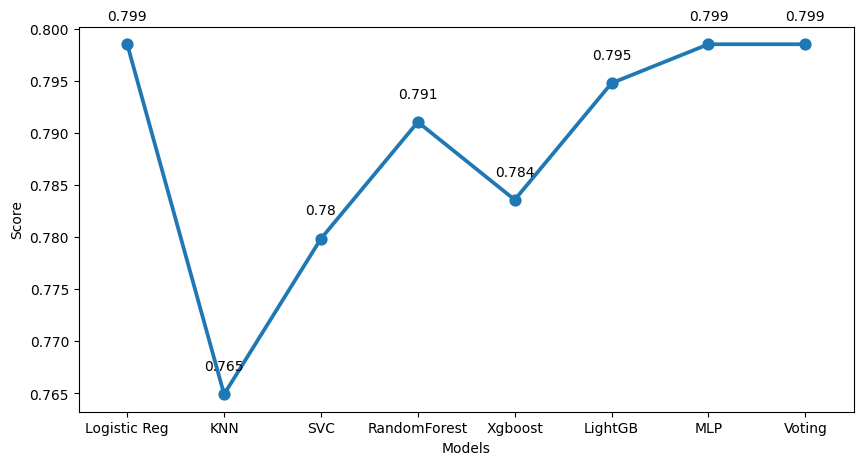

In [ ]:
# Plot the results :
d=pd.concat([pd.DataFrame(res_test,columns=['Score']),pd.DataFrame([*model_names,"Voting"],columns=['Models'])],axis=1)
plt.figure(figsize=(10,5))
sns.pointplot(data=d,x='Models',y='Score')

for i in range(len(res_test)) :
    plt.text(i, res_test[i]+0.002, str(round(res_test[i],3)),verticalalignment='bottom',horizontalalignment='center')


In [ ]:
# Final predictions shape :
path=Path('train_final.csv').parent.absolute()
final_sub=pd.read_csv(path/'gender_submission.csv')
final_sub.shape, final_sub.head()

((418, 2),
    PassengerId  Survived
 0          892         0
 1          893         1
 2          894         0
 3          895         0
 4          896         1)

In [ ]:
confusion_matrix(y_test,preds_test['Logistic Reg']), confusion_matrix(y_test,preds_test['MLP'])

(array([[135,  18],
        [ 36,  79]]),
 array([[136,  17],
        [ 37,  78]]))

In [ ]:
print("Logistic regression :\n", classification_report(y_test,preds_test['Logistic Reg']),"\n")

print("MLP : \n", classification_report(y_test,preds_test['MLP']),"\n")

Logistic regression :
               precision    recall  f1-score   support

           0       0.79      0.88      0.83       153
           1       0.81      0.69      0.75       115

    accuracy                           0.80       268
   macro avg       0.80      0.78      0.79       268
weighted avg       0.80      0.80      0.80       268
 

MLP : 
               precision    recall  f1-score   support

           0       0.79      0.89      0.83       153
           1       0.82      0.68      0.74       115

    accuracy                           0.80       268
   macro avg       0.80      0.78      0.79       268
weighted avg       0.80      0.80      0.80       268
 



<Axes: >

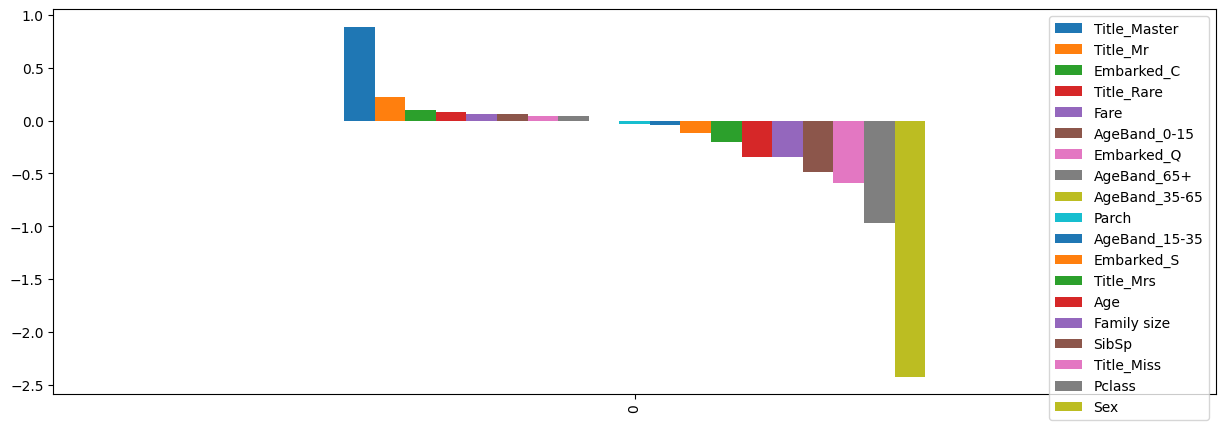

In [ ]:
coef=pd.DataFrame(reglog.coef_,columns=tr.columns)

coef.sort_values(by=0,axis=1,ascending=False,inplace=True)

coef.plot(kind='bar',figsize=(15,5))

In [ ]:
# The best model for submission is the stacking model :
final_sub['Survived']=reglog.predict(test_scaled)
final_sub.head()

# Write final submission in csv file to deliver :
final_sub.to_csv(path/'final_submissions.csv', index=False)

## Tensorflow :

In [89]:
# Get the data and prepare it for tensorflow :
path=Path(Path('train_final.csv').parent.absolute(),Path("Models parameters & Data"))

# Data :
tr=pd.read_csv(path/'train_final.csv')
te=pd.read_csv(path/'test_final.csv')
y=pd.read_csv(path/'y_final.csv')

# Normalization :
scaler=StandardScaler()
scaler.fit(tr)
train_scaled = scaler.transform(tr)
test_scaled = scaler.transform(te) # For the final prediction

print(train_scaled.shape, test_scaled.shape, y.shape)

# Splitting in train / test :
X_train, X_test, y_train, y_test = train_test_split(train_scaled,y,test_size=0.3,random_state=1,shuffle=True) # 70/30%

# Validation set :
X_val, y_val = X_test[:int(len(X_test)*0.5)], y_test[:int(len(X_test)*0.5)]
X_test, y_test = X_test[int(0.5*len(X_test)):], y_test[int(0.5*len(X_test)):]

(891, 19) (418, 19) (891, 1)


In [47]:
# Size of data, small enough to not work on a subset
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape # Data for training and testing

((623, 19), (623, 1), (134, 19), (134, 1), (134, 19), (134, 1))

### Model_0 :

In [111]:
# Create the EarlyStopping callbacks :
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

In [112]:
# Create the model and the different callbacks for the training.
import random
tf.random.set_seed(42)
random.seed(42)

model_0=tf.keras.Sequential([
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(10,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid') #Sigmoid because binary classification
])

model_0.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=['accuracy'])

history_0 = model_0.fit(X_train,y_train,epochs=50,verbose=1,
                        validation_data=[X_val,y_val],callbacks=[early_stopping])

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6486 - loss: 0.6664 - val_accuracy: 0.7761 - val_loss: 0.5834
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8124 - loss: 0.5305 - val_accuracy: 0.7761 - val_loss: 0.5146
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8170 - loss: 0.4516 - val_accuracy: 0.7836 - val_loss: 0.4959
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8283 - loss: 0.4209 - val_accuracy: 0.7985 - val_loss: 0.4870
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8371 - loss: 0.4048 - val_accuracy: 0.8060 - val_loss: 0.4830
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8401 - loss: 0.3946 - val_accuracy: 0.8060 - val_loss: 0.4819
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8399 - loss: 0.3881 - val_accuracy: 0.7836 - val_loss: 0.4824
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8488 - loss: 0.3830 - val_accuracy: 0.7985 - val_lo

<Axes: title={'center': 'Model_0'}>

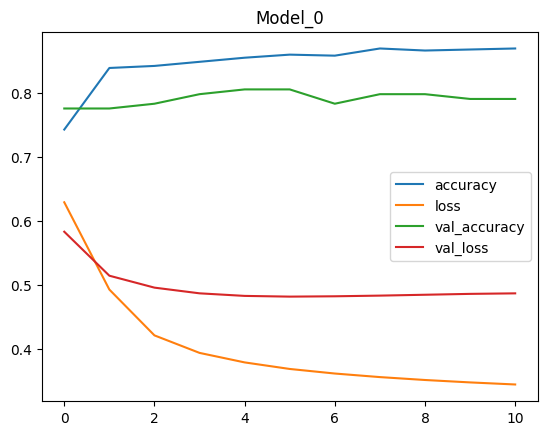

In [113]:
pd.DataFrame(history_0.history).plot(title='Model_0')

### Model_1 :

In [114]:
# Create the model and the different callbacks for the training.
import random
tf.random.set_seed(42)
random.seed(42)

model_1=tf.keras.Sequential([
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(50,activation='relu'),
    tf.keras.layers.Dense(10,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid') #Sigmoid because binary classification
])

model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=['accuracy'])

history_1 = model_1.fit(X_train,y_train,epochs=50,verbose=1,
                        validation_data=[X_val,y_val],callbacks=[early_stopping])

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5712 - loss: 0.7072 - val_accuracy: 0.5970 - val_loss: 0.6228
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6380 - loss: 0.6146 - val_accuracy: 0.7687 - val_loss: 0.5636
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7551 - loss: 0.5443 - val_accuracy: 0.7836 - val_loss: 0.5508
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7860 - loss: 0.5145 - val_accuracy: 0.7761 - val_loss: 0.5285
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8056 - loss: 0.4831 - val_accuracy: 0.7687 - val_loss: 0.5058
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8146 - loss: 0.4562 - val_accuracy: 0.7985 - val_loss: 0.5015
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8124 - loss: 0.4425 - val_accuracy: 0.8060 - val_loss: 0.4911
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8042 - loss: 0.4715 - val_accuracy: 0.7985 - val_loss

<Axes: title={'center': 'Model_1'}>

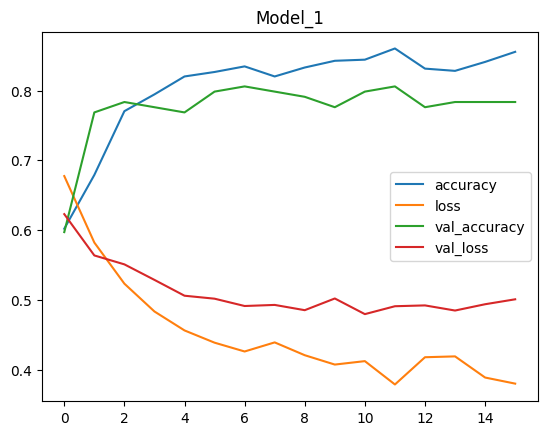

In [115]:
pd.DataFrame(history_1.history).plot(title='Model_1')

### Model_2 :

In [149]:
lr_schedule=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.8,
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)

In [150]:
# Create the model and the different callbacks for the training.
import random
tf.random.set_seed(42)
random.seed(42)

model_2=tf.keras.Sequential([
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(10,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid') #Sigmoid because binary classification
])

model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=['accuracy'])

history_2 = model_2.fit(X_train,y_train,epochs=50,verbose=1,
                        validation_data=[X_val,y_val],callbacks=[early_stopping,lr_schedule])

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6486 - loss: 0.6664 - val_accuracy: 0.7761 - val_loss: 0.5834 - learning_rate: 0.0010
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8124 - loss: 0.5305 - val_accuracy: 0.7761 - val_loss: 0.5146 - learning_rate: 0.0010
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8170 - loss: 0.4516 - val_accuracy: 0.7836 - val_loss: 0.4959 - learning_rate: 0.0010
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8283 - loss: 0.4209 - val_accuracy: 0.7985 - val_loss: 0.4870 - learning_rate: 0.0010
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8371 - loss: 0.4048 - val_accuracy: 0.8060 - val_loss: 0.4830 - learning_rate: 0.0010
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8401 - loss: 0.3946 - val_accuracy: 0.8060 - val_loss: 0.4819 - learning_rate: 0.0010
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8399 - loss: 0.3881 - val_accuracy:

<Axes: title={'center': 'Model_2'}>

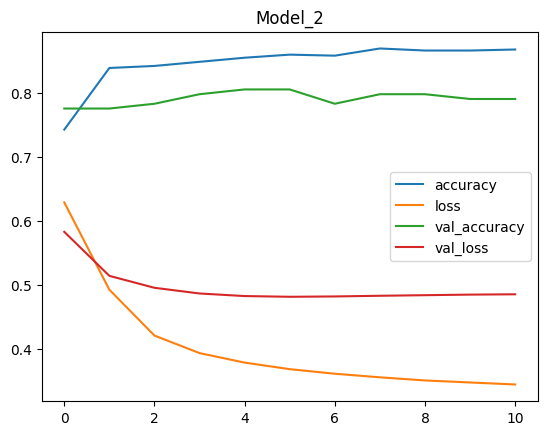

In [151]:
history_2.history.pop("learning_rate")
pd.DataFrame(history_2.history).plot(title='Model_2')

### Evaluating the models on test data :

In [152]:
pred=model_0.predict(X_test).round()
print('Model 0 :', accuracy_score(y_test,pred))

pred=model_1.predict(X_test).round()
print('Model 1 :', accuracy_score(y_test,pred))

pred=model_2.predict(X_test).round()
print('Model 2 :', accuracy_score(y_test,pred))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Model 0 : 0.7835820895522388
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Model 1 : 0.7761194029850746
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Model 2 : 0.7835820895522388
